In [1]:
import catboost
import re
#import bamboolib as bam
import pandas as pd
import sys
import re
from bs4 import BeautifulSoup as bs
from email.parser import BytesParser
from email.policy import default
import mailbox

import nltk.corpus
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def get_df(path_to_mailbox):

    dataset = []
    i = 0
    mp_val = 0
    mbox = mailbox.mbox(path_to_mailbox, factory=BytesParser(policy=default).parse)    

    for _, message in enumerate(mbox):

        content = message.get_payload()
        #print(type(content))
            
        #print("content:", content)

        # life hack with nested multipart mails (we need to process them sep)
        content = bs(content, 'html.parser').get_text()
        # if isinstance(content,list):
        #     continue
        
        # try:
        #     content = bs(content, 'html.parser').get_text()
        # except:
        #     pass

        if message.is_multipart():
            mp_val = 1 

        dataset.append({
          'xuid': message['x-uid'],
          'from': message['From'],        
          'subject': message['Subject'],
          'content': bs(message.get_payload(), 'html.parser').get_text(),   
          'content_type': message['Content-Type'],        
          'multipart': 1       
        })          

        print(f"{i}. **************************************")

        i += 1
        # if i == 5:
        #     break
    dataset = pd.DataFrame(dataset)
    return dataset

In [15]:
MAX_MAILS = 5
path_to_mailbox_test = 'dataset/test.mbox'
path_to_mailbox_train = 'dataset/train.mbox'

train = get_df(path_to_mailbox_test)
test = get_df(path_to_mailbox_train)

0. **************************************


TypeError: expected string or bytes-like object

In [10]:
train['target'] = 0
test['target'] = 1

df = pd.concat([train,test])
df

TypeError: list indices must be integers or slices, not str

In [2]:
def clean(text):
    text = text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((not i.isdigit()) and len(i)>2 and i in nouns)])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
    
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()


df['clear_text'] = df['content']
df['clear_text'] = df['clear_text'].str.lower()
df['clear_text'] = df['clear_text'].apply(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", x)) # Removing Unicode Characters
df['clear_text'] = df['clear_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split() if word not in (stop)]) ) # Лематизация 

df[['content','clear_text']]


id                                               text  label
0          0  Температура тела : 36,5 С\nВеc, кг : 74 ,\nРос...    0.0
1          1  Педикулез : отр\nЧесотка : отр\nИБС СН 2фк\nДа...    0.0
2          2  Температура тела : 36,4 С\nВеc, кг : 73 ,\nРос...    0.0
3          3  Температура тела : 36,4 С\nВеc, кг : 92\nРост,...    0.0
4          4  Педикулез : отр\nЧесотка : отр\nФлюорограмма Н...    0.0
...      ...                                                ...    ...
79331  79335  Множественная миома матки.\nДата поступления в...    0.0
79332  79336  Температура тела : 36,5 С\nВеc, кг : 85 ,\nРос...    0.0
79333  79337  Дата начала действия : 01.11.2016\nВид поступл...    0.0
79334  79338  Код по МКБ10 : G44.1 Сосудистая головная боль,...    0.0
79335  79339  Температура тела : 36,6 С\nВеc, кг : 75 ,\nРос...    0.0

[79336 rows x 3 columns]

In [ ]:
print('')

  #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them

# Извлечь номера телефона
        phone_re = re.findall(r'[\+\(]?[1-9][0-9 \-\(\)]{8,}[0-9]', content)
        phone_re = list(filter(lambda x: len(x) >= 15, phone_re))

        # Извлечь сайты
        urls_re = re.findall('\S+:\S+',  content) 
        urls_re = list(filter(lambda x: len(x) >= 6, urls_re))

        # Извлечь емейл
        emails_re = re.findall(r'\w+@\w+.\w+', content)

        pattern = r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}"
        pattern_re = re.compile(pattern)
        ip_address = pattern_re.findall(content)
          
        print("urls:", urls_re)
        print("emails:", emails_re)
        print("nums:", phone_re)
        print("ips:", ip_address)

In [3]:
df.head()

id                                               text  label
0   0  Температура тела : 36,5 С\nВеc, кг : 74 ,\nРос...    0.0
1   1  Педикулез : отр\nЧесотка : отр\nИБС СН 2фк\nДа...    0.0
2   2  Температура тела : 36,4 С\nВеc, кг : 73 ,\nРос...    0.0
3   3  Температура тела : 36,4 С\nВеc, кг : 92\nРост,...    0.0
4   4  Педикулез : отр\nЧесотка : отр\nФлюорограмма Н...    0.0

In [5]:
new_df = df['text']

In [6]:
new_df[1]

'Педикулез : отр\nЧесотка : отр\nИБС СН 2фк\nДата поступления в приемное отделение : 19.01.2016\nВремя поступления в приемное отделение : 15:33\nГоспитализирован по поводу данного заболевания в текущем году : повторно\nПорядок госпитализации : планово : направившее учреждение : Комитет_здравоохранения Санкт-Петербурга\nСпособ поступления (доставки) : самостоятельно\nЦель поступления : Оперативное_лечение\nКанал поступления: \nНа момент осмотра жалоб не предъявляет\nПовышение АД в течение длительного времени, макс — 180/100 мм рт ст, адаптирован к 130/90 мм рт ст. Гипотензивные препараты принимает регулярно. Клинику стенокардии, ОИМ, ОНМК в анамнезе отрицает. Регулярно наблюдается у кардиолога. Обследован амбулаторно в плановом порядке. По данным ЭХОКГ от 29.12.15г — ФВ- 62%, зон нарушения локальной сократимости ЛЖ не выявлено, гемодинамически значимой клапанной патологии не выявлено.09.11.2015. проведена СТРЕСС-ЭХО-КГ- тест положительный (4,6 МЕТs). Определены показания к проведению КА

In [7]:
PRINT_OUTPUT = False

def printer(*args):
    if PRINT_OUTPUT:
        print(*args)
    else:
        pass

def extract_data(signature):
    result = None
    if not result:
        try:
            s = sample
            last = '\n'
            start = s.index( signature ) + len( signature )
            end = s.index( last, start )
            return s[start:end]
        except ValueError:
            return ""
    else:
        return result

def check_case(data, case):
    if data is not None and len(data) > 1:
        if data.find(case) == -1:
            return 0.0
        else:
            return 1.0
    else: return '<invalid>'

def classify_answer(answ):
    if answ is not None and isinstance(answ, str):
        if len(answ) > 1:
            if 'отрицает' in answ or 'отр' in answ:
                return 0.0
            elif 'первично' in answ:
                return 0.0
            elif 'обычной_окраски' in answ:
                return 0.0
            elif 'без_патологии' in answ:
                return 0.0
            elif 'работает' in answ:
                return 0.0
            elif 'планово' in answ:
                return 0.0
            elif 'правильной_формы' in answ:
                return 0.0
            elif 'не_пальпируется' in answ:
                return 0.0
            elif 'не_участвуют' in answ:
                return 0.0
            elif 'не_слышны' in answ:
                return 0.0
            elif 'лечебно-диагностическая' in answ:
                return 0.0
            elif 'без особенностей' in answ:
                return 0.0
            elif 'самостоятельно' in answ:
                return 0.0
            elif 'не_выражена' in answ:
                return 0.0
            elif 'не_увеличены' in answ:
                return 0.0
            elif 'чистый' in answ:
                return 0.0
            elif 'чистые' in answ:
                return 0.0
            elif 'ясное' in answ:
                return 0.0
            elif 'вступает_легко' in answ:
                return 0.0
            elif 'удовлетворительное' in answ:
                return 0.0
            elif 'удовлетворительно' in answ:
                return 0.0
            elif 'удовлетворительные' in answ:
                return 0.0
            elif 'ориентирован' in answ:
                return 0.0
            elif 'правильное' in answ:
                return 0.0
            elif 'нет' in answ:
                return 0.0
            elif 'не_определяются' in answ:
                return 0.0
            elif 'перианальная область не изменена' in answ:
                return 0.0
            elif 'мягкий' in answ:
                return 0.0
            elif 'безболезненный' in answ:
                return 0.0
            else: return 1.0
        else: return '<invalid>'
    else: return '<invalid>'

def extract_float(answ):
    if answ is not None and len(answ) > 1 and isinstance(answ, str):
        answ = answ.replace(',','.')
        searchMatch = re.findall("\s*\d+.?\d+\s*",answ)
        if searchMatch:
            floatValue = searchMatch[0]
            floatValue = float(floatValue)
            return floatValue
        else:
            return '<invalid>'
    else: return '<invalid>'

In [8]:
from datetime import datetime
start_time = datetime.now()

columns_set=[
         'id',
         'temperatura',
         'ves',
         'rost',
         'pedikulez_status',
         'chesotka_status',
         'flyurogramma',
         'gepatit_status',
         'spid_status',
         'hron_bolezn_pecheni_status',
         'operativnie_vmeshatelstva',
         'perelivanie_krovi_status',
         'kontakti_s_inficirovannimi',
         'prebivanie_zagranicey',
         'lihoradka_status',
         'saharniy_diabet_status',
         'ostr_serdsosudistaya_nedost_status',
         'gepatit_c_status',
         'letal_status',
         'sepsis_status',
         'mas_krovopoterya_status',
         'polip_kishki',
         'gospitalizirovan',
         'poryadok_gosp',
         'sposob_postupleniya',
         'cel_postupleniya',
         'strahov_anamnez',
         'allergologicheskiy_anamnez',
         'vred_privichki',
         'obraz_jizni',
         'obshee_sost',
         'temperatura_utro',
         'temperatura_vecher',
         'soznanie',
         'v_kontakte',
         'emotionalnaya_labilnost',
         'orientacia_v_prostr',
         'teloslojenie',
         'invalidnost',
         'sost_pitaniya',
         'index_massi_tela',
         'ploshad_poverhn_tela',
         'kojnie_pokrovi',
         'skleri_status',
         'vidimie_slizistie',
         'kostno_mishechnaya_sistema',
         'zev',
         'peref_limfouzli',
         'oteki',
         'shitovidnaya_jeleza',
         'selezenka',
         #'serd_sodud_sistema',
         'forma_gr_kletki',
         'chislo_dihaniy',
         'pishevar_sistema',
         'rektalno',
         #'organi_mocheispuscaniya',
         ]
clean_df = pd.DataFrame(columns=columns_set)

id = 0

for i in enumerate(new_df):
    try:
        sample = i[1]

        sample = sample.replace(' : ', ':')
        sample = sample.replace('pattern','')
        sample = sample.lower()

        temperatura = extract_data('температура тела:')
        if len(temperatura) < 1:
            temperatura = extract_data('температура:')
        temperatura = extract_float(temperatura)
        printer("Температура: ", temperatura)

        ves = extract_data('веc:')
        if len(ves) < 1:
            ves = extract_data('веc, кг:')
        ves = extract_float(ves)
        printer("Вес: ", ves)

        rost = extract_data('рост:')
        if len(rost) < 1:
            rost = extract_data('рост, см:')
        rost = extract_float(rost)
        printer("Рост: ", rost)

        pedikulez_status = extract_data('педикулез:')
        pedikulez_status = classify_answer(pedikulez_status)
        printer("Педикулез: ", pedikulez_status)

        chesotka_status = extract_data('чесотка:')
        chesotka_status = classify_answer(chesotka_status)
        printer("Чесотка: ", chesotka_status)

        flyurogramma = extract_data('флюорограмма ')
        flyurogramma = classify_answer(flyurogramma)
        printer("Флюорограмма: ", flyurogramma)

        gepatit_status = extract_data('гепатит ')
        gepatit_status = classify_answer(gepatit_status)
        printer("Гепатит: ", gepatit_status)

        spid_status = extract_data('вич:')
        if len(spid_status) < 1:
            spid_status = extract_data('вич (спид):')
        if len(spid_status) < 1:
            spid_status = check_case(sample, 'b23-инфекция')
        spid_status = classify_answer(spid_status)
        printer("ВИЧ: ", spid_status)

        hron_bolezn_pecheni_status = extract_data('хронические заболевания печени:')
        hron_bolezn_pecheni_status = classify_answer(hron_bolezn_pecheni_status)
        printer("Хронические заболевания печени: ", hron_bolezn_pecheni_status)

        operativnie_vmeshatelstva = extract_data('оперативные вмешательства:')
        operativnie_vmeshatelstva = classify_answer(operativnie_vmeshatelstva)
        printer("Оперативные вмешательства: ", operativnie_vmeshatelstva)

        perelivanie_krovi_status = extract_data('переливание крови:')
        perelivanie_krovi_status = classify_answer(perelivanie_krovi_status)
        printer("Переливание крови: ", perelivanie_krovi_status)

        kontakti_s_inficirovannimi = extract_data('контакты с инфекционными больными:')
        kontakti_s_inficirovannimi = classify_answer(kontakti_s_inficirovannimi)
        printer("Контакты с инфекционными больными: ", kontakti_s_inficirovannimi)

        prebivanie_zagranicey = extract_data('пребывание за границей:')
        prebivanie_zagranicey = classify_answer(prebivanie_zagranicey)
        printer("Пребывание за границей: ", prebivanie_zagranicey)

        lihoradka_status = extract_data('лихорадка:')
        lihoradka_status = classify_answer(lihoradka_status)
        printer("Лихорадка: ", lihoradka_status)

        soznanie = extract_data('сознание ')
        soznanie = classify_answer(soznanie)
        printer("Сознание: ", soznanie)

        v_kontakte = extract_data('в контакт ')
        v_kontakte = classify_answer(v_kontakte)
        printer("В контакте: ", v_kontakte)

        #################################################################################
        saharniy_diabet_status = check_case(sample, 'сахарный диабет ii типа')
        printer("Cахарный диабет II типа: ", saharniy_diabet_status)

        ostr_serdsosudistaya_nedost_status = check_case(sample, 'острая сердечно - сосудистая недостаточность')
        if ostr_serdsosudistaya_nedost_status != 1.0:
            ostr_serdsosudistaya_nedost_status = check_case(sample, 'острая сердечная нед-ть')
        if ostr_serdsosudistaya_nedost_status != 1.0:
            ostr_serdsosudistaya_nedost_status = check_case(sample, 'острая сердечно-сосудистая недостаточность')
        printer('Острая сердечно-сосудистая недостаточность', ostr_serdsosudistaya_nedost_status)

        gepatit_c_status = check_case(sample, 'хронический вирусный гепатит c')
        printer("Cахарный диабет II типа: ", gepatit_c_status)

        letal_status = check_case(sample, 'прогноз крайне неблагоприятный')
        if letal_status != 1:
            letal_status = check_case(sample, 'риск летального исхода')
        if letal_status != 1:
            letal_status = check_case(sample, 'с летальным исходом')
        if letal_status != 1:
            letal_status = check_case(sample, 'возможного летального исхода')
        if letal_status != 1:
            letal_status = check_case(sample, 'возможными исходами манипуляции (включая летальный)')
        if letal_status != 1:
            letal_status = check_case(sample, 'ст 4b прогрессирование')
        if letal_status != 1:
            letal_status = check_case(sample, 'трансплантаци')
        printer("риск летального исхода: ", letal_status)

        sepsis_status = check_case(sample, 'тяжелый сепсис')
        printer("тяжелый сепсис: ", sepsis_status)

        mas_krovopoterya_status = check_case(sample, 'массивной кровопотери')
        if mas_krovopoterya_status != 1.0:
            mas_krovopoterya_status = check_case(sample, 'массивная кровопотеря')
        printer("массивная кровопотеря: ", mas_krovopoterya_status)

        if ostr_serdsosudistaya_nedost_status > 0 or gepatit_c_status > 0 or letal_status  > 0 or sepsis_status or mas_krovopoterya_status > 0:
            letal_status = 1
        else:
            letal_status = 0

        # or lihoradka_status > 0 or soznanie > 0 or v_kontakte > 0
        print("риск летального исхода: ", letal_status)
        #################################################################################

        polip_kishki = check_case(sample, 'полип ободочной')
        if polip_kishki != 1.0:
            polip_kishki = check_case(sample, 'полипы кишки')
        if polip_kishki != 1.0:
            polip_kishki = check_case(sample, 'полипы желудка')
        printer("Полипы: ", polip_kishki)

        gospitalizirovan = extract_data('госпитализирован по поводу данного заболевания в текущем году:')
        gospitalizirovan = classify_answer(gospitalizirovan)
        printer("Госпитализирован по поводу данного заболевания в текущем году: ", gospitalizirovan)

        poryadok_gosp = extract_data('порядок госпитализации:')
        poryadok_gosp = classify_answer(poryadok_gosp)
        printer("Порядок госпитализации: ",poryadok_gosp)

        sposob_postupleniya = extract_data('способ поступления (доставки):')
        if len(sposob_postupleniya) < 1:
            sposob_postupleniya = extract_data('способ поступления:')
            if len(sposob_postupleniya) < 1:
                sposob_postupleniya = extract_data('способ транспортировки:')
        sposob_postupleniya = classify_answer(sposob_postupleniya)
        printer("Способ поступления: ", sposob_postupleniya)

        cel_postupleniya = extract_data('цель поступления:')
        cel_postupleniya = classify_answer(cel_postupleniya)
        printer("Цель поступления: ", cel_postupleniya)

        strahov_anamnez = extract_data('страховой анамнез:')
        strahov_anamnez = classify_answer(strahov_anamnez)
        printer("Страховой анамнез: ", strahov_anamnez)

        allergologicheskiy_anamnez = extract_data('аллергологический анамнез:')
        allergologicheskiy_anamnez = classify_answer(allergologicheskiy_anamnez)
        printer("Аллергологический анамнез: ", allergologicheskiy_anamnez)

        vred_privichki = extract_data('вредные привычки:')
        vred_privichki = classify_answer(vred_privichki)
        printer("Вредные привычки: ", vred_privichki)

        obraz_jizni = extract_data('образ жизни:')
        obraz_jizni = classify_answer(obraz_jizni)
        printer("Образ жизни: ", obraz_jizni)

        obshee_sost = extract_data('общее состояние ')
        obshee_sost = classify_answer(obshee_sost)
        printer("Общее состояние: ",obshee_sost)

        temperatura_utro = extract_data('температура тела:утро:') # 36,6 ; вечер:36,6
        temperatura_utro = extract_float(temperatura_utro)
        printer("Температура тела : утро: ", temperatura_utro)

        temperatura_vecher = extract_data('температура тела:утро:36,6 ; вечер:')
        temperatura_vecher = extract_float(temperatura_vecher)
        printer("Температура тела : вечер: ", temperatura_vecher)

        emotionalnaya_labilnost = extract_data('эмоциональная лабильность ')
        emotionalnaya_labilnost = classify_answer(emotionalnaya_labilnost)
        printer("Эмоциональная лабильность: ", emotionalnaya_labilnost)

        orientacia_v_prostr = extract_data('в пространстве и времени ')
        orientacia_v_prostr = classify_answer(orientacia_v_prostr)
        printer("Ориентация в пространстве и времени: ", orientacia_v_prostr)

        teloslojenie = extract_data('телосложение ')
        teloslojenie = classify_answer(teloslojenie)
        printer("Телосложение: ", teloslojenie)

        invalidnost = extract_data('инвалидность  ')
        invalidnost = classify_answer(invalidnost)
        printer("Инвалидность: ", teloslojenie)

        sost_pitaniya = extract_data('состояние питания ')
        sost_pitaniya = classify_answer(sost_pitaniya)
        printer("Состояние питания: ", sost_pitaniya)

        index_massi_tela = extract_data('индекс массы тела ')
        index_massi_tela = extract_float(index_massi_tela)
        printer("Индекс массы тела: ", index_massi_tela)

        ploshad_poverhn_tela = extract_data('площадь поверхности тела ')
        ploshad_poverhn_tela = extract_float(ploshad_poverhn_tela)
        printer("Площадь поверхности тела: ", ploshad_poverhn_tela)

        kojnie_pokrovi = extract_data('кожные покровы ')
        kojnie_pokrovi = classify_answer(kojnie_pokrovi)
        printer("Кожные покровы: ", kojnie_pokrovi)

        skleri_status = extract_data('склеры ')
        skleri_status = classify_answer(skleri_status)
        printer("Склеры: ", skleri_status)

        vidimie_slizistie = extract_data('видимые слизистые оболочки ')
        vidimie_slizistie = classify_answer(vidimie_slizistie)
        printer("Видимые слизистые оболочки: ", vidimie_slizistie)

        kostno_mishechnaya_sistema = extract_data('костно-мышечная система ')
        kostno_mishechnaya_sistema = classify_answer(kostno_mishechnaya_sistema)
        printer("Костно-мышечная система: ", kostno_mishechnaya_sistema)

        zev = extract_data('зев ')
        zev = classify_answer(zev)
        printer("Зев: ", zev)

        peref_limfouzli = extract_data('периферические лимфоузлы:')
        peref_limfouzli = classify_answer(peref_limfouzli)
        printer("gериферические лимфоузлы: ", peref_limfouzli)

        oteki = extract_data('отеки:')
        oteki = classify_answer(oteki)
        printer("Отеки: ", oteki)

        shitovidnaya_jeleza = extract_data('щитовидная железа:')
        shitovidnaya_jeleza = classify_answer(shitovidnaya_jeleza)
        printer("щитовидная железа: ", shitovidnaya_jeleza)

        selezenka = extract_data('cелезенка ')
        if len(selezenka) < 1:
            selezenka = extract_data('cелезенка:')
        selezenka = classify_answer(selezenka)
        printer("Селезенка: ", selezenka)

        # serd_sodud_sistema = extract_data('сердечно-сосудистая система:')
        # print(serd_sodud_sistema)

        forma_gr_kletki = extract_data('Грудная клетка ')
        forma_gr_kletki = classify_answer(forma_gr_kletki)
        printer(forma_gr_kletki)

        chislo_dihaniy = extract_data('число дыханий в 1 мин.')
        chislo_dihaniy = extract_float(chislo_dihaniy)
        printer("число дыханий в 1 мин: ", chislo_dihaniy)

        pishevar_sistema = extract_data('пищеварительная система:')
        pishevar_sistema = classify_answer(pishevar_sistema)
        printer("Пищеварительная система: ", pishevar_sistema)

        rektalno = extract_data('ректально:')
        rektalno = classify_answer(rektalno)
        printer("Ректально: ", rektalno)

        organi_mocheispuscaniya = extract_data('органы мочеиспускания:')
        printer(organi_mocheispuscaniya)

        diagnoz_osnovnoy = extract_data('диагноз уточненный_основной:')
        printer("диагноз уточненный_основной: ", diagnoz_osnovnoy)

        diagnoz_kod = extract_data('код по мкб10:')
        printer("Код по МКБ10: ", diagnoz_kod)

        diagnoz_osnovnoy = extract_data('диагноз_поступления_основной:')
        printer("ДИАГНОЗ_ПОСТУПЛЕНИЯ_ОСНОВНОЙ: ", diagnoz_osnovnoy)

        diagnoz_opisanie = extract_data('nnnnnnnnn,')
        printer("ДИАГНОЗ_ОПИСАНИЕ_ОСНОВНОЙ: ", diagnoz_opisanie)

        print('===' * 40)
        print(id)
        print('===' * 40)

        clean_df = clean_df.append(pd.DataFrame({
            'id':id,
            'temperatura':temperatura,
            'ves':ves,
            'rost':rost,
            'pedikulez_status':pedikulez_status,
            'chesotka_status':chesotka_status,
            'flyurogramma':flyurogramma,
            'gepatit_status':gepatit_status,
            'spid_status':spid_status,
            'hron_bolezn_pecheni_status':hron_bolezn_pecheni_status,
            'operativnie_vmeshatelstva':operativnie_vmeshatelstva,
            'perelivanie_krovi_status':perelivanie_krovi_status,
            'kontakti_s_inficirovannimi':kontakti_s_inficirovannimi,
            'prebivanie_zagranicey':prebivanie_zagranicey,
            'lihoradka_status':lihoradka_status,
            'saharniy_diabet_status':saharniy_diabet_status,
            'ostr_serdsosudistaya_nedost_status':ostr_serdsosudistaya_nedost_status,
            'gepatit_c_status':gepatit_c_status,
            'letal_status':letal_status,
            'sepsis_status':sepsis_status,
            'mas_krovopoterya_status':mas_krovopoterya_status,
            'polip_kishki':polip_kishki,
            'gospitalizirovan':gospitalizirovan,
            'poryadok_gosp':poryadok_gosp,
            'sposob_postupleniya':sposob_postupleniya,
            'cel_postupleniya':cel_postupleniya,
            'strahov_anamnez':strahov_anamnez,
            'allergologicheskiy_anamnez':allergologicheskiy_anamnez,
            'vred_privichki':vred_privichki,
            'obraz_jizni':obraz_jizni,
            'obshee_sost':obshee_sost,
            'temperatura_utro':temperatura_utro,
            'temperatura_vecher':temperatura_vecher,
            'soznanie':soznanie,
            'v_kontakte':v_kontakte,
            'emotionalnaya_labilnost':emotionalnaya_labilnost,
            'orientacia_v_prostr':orientacia_v_prostr,
            'teloslojenie':teloslojenie,
            'invalidnost':invalidnost,
            'sost_pitaniya':sost_pitaniya,
            'index_massi_tela':index_massi_tela,
            'ploshad_poverhn_tela':ploshad_poverhn_tela,
            'kojnie_pokrovi':kojnie_pokrovi,
            'skleri_status':skleri_status,
            'vidimie_slizistie':vidimie_slizistie,
            'kostno_mishechnaya_sistema':kostno_mishechnaya_sistema,
            'zev':zev,
            'peref_limfouzli':peref_limfouzli,
            'oteki':oteki,
            'shitovidnaya_jeleza':shitovidnaya_jeleza,
            'selezenka':selezenka,
            #'serd_sodud_sistema':serd_sodud_sistema,
            'forma_gr_kletki':forma_gr_kletki,
            'chislo_dihaniy':chislo_dihaniy,
            'pishevar_sistema':pishevar_sistema,
            'rektalno':rektalno,
            #'organi_mocheispuscaniya':organi_mocheispuscaniya,
        }, index=[id]), ignore_index=False)

        id += 1
        if id == 5000:#len(df.index):
            break
    except:
        print("Ошибка при обработке данных о пациенте, продолжаем...")

time_elapsed = datetime.now() - start_time
print('Всего времени затрачено на обработку (hh:mm:ss) {}'.format(time_elapsed))

риск летального исхода:  0
0
риск летального исхода:  0
1
риск летального исхода:  0
2
риск летального исхода:  0
3
риск летального исхода:  0
4
риск летального исхода:  0
5
риск летального исхода:  0
6
риск летального исхода:  0
7
риск летального исхода:  0
8
риск летального исхода:  0
9
риск летального исхода:  0
10
риск летального исхода:  0
11
риск летального исхода:  0
12
риск летального исхода:  0
13
риск летального исхода:  0
14
риск летального исхода:  0
15
риск летального исхода:  0
16
риск летального исхода:  0
17
риск летального исхода:  0
18
риск летального исхода:  0
19
риск летального исхода:  0
20
риск летального исхода:  0
21
риск летального исхода:  0
22
риск летального исхода:  0
23
риск летального исхода:  0
24
риск летального исхода:  0
25
риск летального исхода:  0
26
риск летального исхода:  0
27
риск летального исхода:  0
28
риск летального исхода:  0
29
риск летального исхода:  0
30
риск летального исхода:  0
31
риск летального исхода:  0
32
риск летального исхо

In [9]:
clean_df = clean_df.replace(['<invalid>'], '0.0')
clean_df

id temperatura  ves rost pedikulez_status chesotka_status  \
0        0        36.5   74  176                0               0   
1        1         0.0  0.0  0.0                0               0   
2        2        36.4   73  174                0               0   
3        3        36.4   92  165                0               0   
4        4         0.0  0.0  0.0                0               0   
...    ...         ...  ...  ...              ...             ...   
4995  4995        36.5  0.0  0.0                0               0   
4996  4996        36.6  162   72                0               0   
4997  4997        36.6   70  167                0               0   
4998  4998        36.5   67  167                0               0   
4999  4999        36.6   67  167                0               0   

     flyurogramma gepatit_status spid_status hron_bolezn_pecheni_status  ...  \
0               0              0         0.0                          0  ...   
1             0.0              0         0.0                        0.0  ...   
2               0              0           0                          0  ...   
3               0              1         0.0                          0  ...   
4               0              0         0.0                          0  ...   
...           ...            ...         ...                        ...  ...   
4995            1              0           0                          0  ...   
4996            0              0           0                          0  ...   
4997            1              0           0                          0  ...   
4998            1              0           0                          0  ...   
4999            1              0           0                          0  ...   

     kostno_mishechnaya_sistema  zev peref_limfouzli oteki  \
0                           0.0  0.0             0.0     0   
1                           0.0  0.0               0     0   
2                             0    0               0     0   
3                           0.0  0.0             0.0   0.0   
4                           0.0  0.0               0     0   
...                         ...  ...             ...   ...   
4995                          0    0               0     0   
4996                          0    0               0     1   
4997                          0    0               0     0   
4998                          0    0               0     0   
4999                        0.0  0.0               0     1   

     shitovidnaya_jeleza  selezenka  forma_gr_kletki  chislo_dihaniy  \
0                      1        0.0              0.0             0.0   
1                      1        0.0              0.0              15   
2                      1        0.0              0.0              16   
3                    0.0        0.0              0.0             0.0   
4                      1        0.0              0.0              12   
...                  ...        ...              ...             ...   
4995                   1        0.0              0.0              15   
4996                   1        0.0              0.0              18   
4997                   1        0.0              0.0              16   
4998                   1        0.0              0.0              17   
4999                   1        0.0              0.0             0.0   

      pishevar_sistema  rektalno  
0                  0.0       0.0  
1                    0       0.0  
2                    0       0.0  
3                  0.0       0.0  
4                    0       0.0  
...                ...       ...  
4995                 0       0.0  
4996                 0       0.0  
4997                 0       0.0  
4998                 0       0.0  
4999                 0       0.0  

[5000 rows x 55 columns]

In [10]:
clean_df.to_csv("processed.csv", sep=',', encoding='utf-8')

In [11]:
clean_df.describe()

id  saharniy_diabet_status  \
count  5000.000000             5000.000000   
mean   2499.500000                0.152400   
std    1443.520003                0.359444   
min       0.000000                0.000000   
25%    1249.750000                0.000000   
50%    2499.500000                0.000000   
75%    3749.250000                0.000000   
max    4999.000000                1.000000   

       ostr_serdsosudistaya_nedost_status  gepatit_c_status  letal_status  \
count                              5000.0       5000.000000   5000.000000   
mean                                  0.0          0.000400      0.044400   
std                                   0.0          0.019998      0.206003   
min                                   0.0          0.000000      0.000000   
25%                                   0.0          0.000000      0.000000   
50%                                   0.0          0.000000      0.000000   
75%                                   0.0          0.000000      0.000000   
max                                   0.0          1.000000      1.000000   

       sepsis_status  mas_krovopoterya_status  polip_kishki  
count         5000.0                   5000.0   5000.000000  
mean             0.0                      0.0      0.001800  
std              0.0                      0.0      0.042392  
min              0.0                      0.0      0.000000  
25%              0.0                      0.0      0.000000  
50%              0.0                      0.0      0.000000  
75%              0.0                      0.0      0.000000  
max              0.0                      0.0      1.000000

In [12]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  5000 non-null   int64  
 1   temperatura                         5000 non-null   object 
 2   ves                                 5000 non-null   object 
 3   rost                                5000 non-null   object 
 4   pedikulez_status                    5000 non-null   object 
 5   chesotka_status                     5000 non-null   object 
 6   flyurogramma                        5000 non-null   object 
 7   gepatit_status                      5000 non-null   object 
 8   spid_status                         5000 non-null   object 
 9   hron_bolezn_pecheni_status          5000 non-null   object 
 10  operativnie_vmeshatelstva           5000 non-null   object 
 11  perelivanie_krovi_status            5000 no

In [13]:
clean_df.groupby(letal_status['letal_status']).size()

TypeError: 'int' object is not subscriptable

In [14]:
y = clean_df['letal_status'].values

features_to_drop = ['letal_status','id']

cutted = clean_df.drop(features_to_drop,axis=1)
X = cutted.values

In [15]:
import os
import pandas as pd
import numpy as np
import pickle
# import pefile
import sklearn.ensemble as ek
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [30]:
extratrees = ek.ExtraTreesClassifier(n_estimators=300).fit(X,y)
model = SelectFromModel(extratrees, prefit=True)
X_new = model.transform(X)
nbfeatures = X_new.shape[1]
nbfeatures

17

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25)

In [32]:
features = []
index = np.argsort(extratrees.feature_importances_)[::-1][:nbfeatures]

In [33]:
for f in range(nbfeatures):
    print("%d. feature %s (%f)" % (f, cutted.columns[index[f]], 10 * extratrees.feature_importances_[index[f]]))
    features.append(cutted.columns[index[f]])

0. feature ploshad_poverhn_tela (1.193250)
1. feature index_massi_tela (1.133674)
2. feature rost (0.839391)
3. feature ves (0.809485)
4. feature chislo_dihaniy (0.672545)
5. feature temperatura (0.624608)
6. feature vred_privichki (0.609218)
7. feature flyurogramma (0.363260)
8. feature operativnie_vmeshatelstva (0.273330)
9. feature obshee_sost (0.270203)
10. feature temperatura_utro (0.254607)
11. feature allergologicheskiy_anamnez (0.253951)
12. feature cel_postupleniya (0.245075)
13. feature hron_bolezn_pecheni_status (0.227459)
14. feature gospitalizirovan (0.204239)
15. feature vidimie_slizistie (0.197696)
16. feature gepatit_status (0.191680)


In [34]:
fti = extratrees.feature_importances_
for i, feat in enumerate(features):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	ploshad_poverhn_tela : 0.062461
	index_massi_tela     : 0.080948
	rost                 : 0.083939
	ves                  : 0.000000
	chislo_dihaniy       : 0.000000
	temperatura          : 0.036326
	vred_privichki       : 0.019168
	flyurogramma         : 0.000257
	operativnie_vmeshatelstva : 0.022746
	obshee_sost          : 0.027333
	temperatura_utro     : 0.012434
	allergologicheskiy_anamnez : 0.000819
	cel_postupleniya     : 0.001494
	hron_bolezn_pecheni_status : 0.009861
	gospitalizirovan     : 0.015318
	vidimie_slizistie    : 0.000000
	gepatit_status       : 0.008346


In [35]:
model = {"DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
    "RandomForest":ek.RandomForestClassifier(criterion = 'gini', max_depth = 7, max_features = 'auto', n_estimators = 200),
    #"Adaboost":ek.AdaBoostClassifier(n_estimators=50),
    "GradientBoosting":ek.GradientBoostingClassifier(n_estimators=50),
    #"GNB":GaussianNB(),
    "LinearRegression":LinearRegression()
}

In [27]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

DecisionTree : 0.956 
RandomForest : 0.9672 
GradientBoosting : 0.964 
LinearRegression : 0.046745687309469264 


In [36]:
winner = max(results, key=results.get)
print ("Using %s" %(model[winner]))

Using RandomForestClassifier(max_depth=7, n_estimators=200)


In [37]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

0.9853333333333333


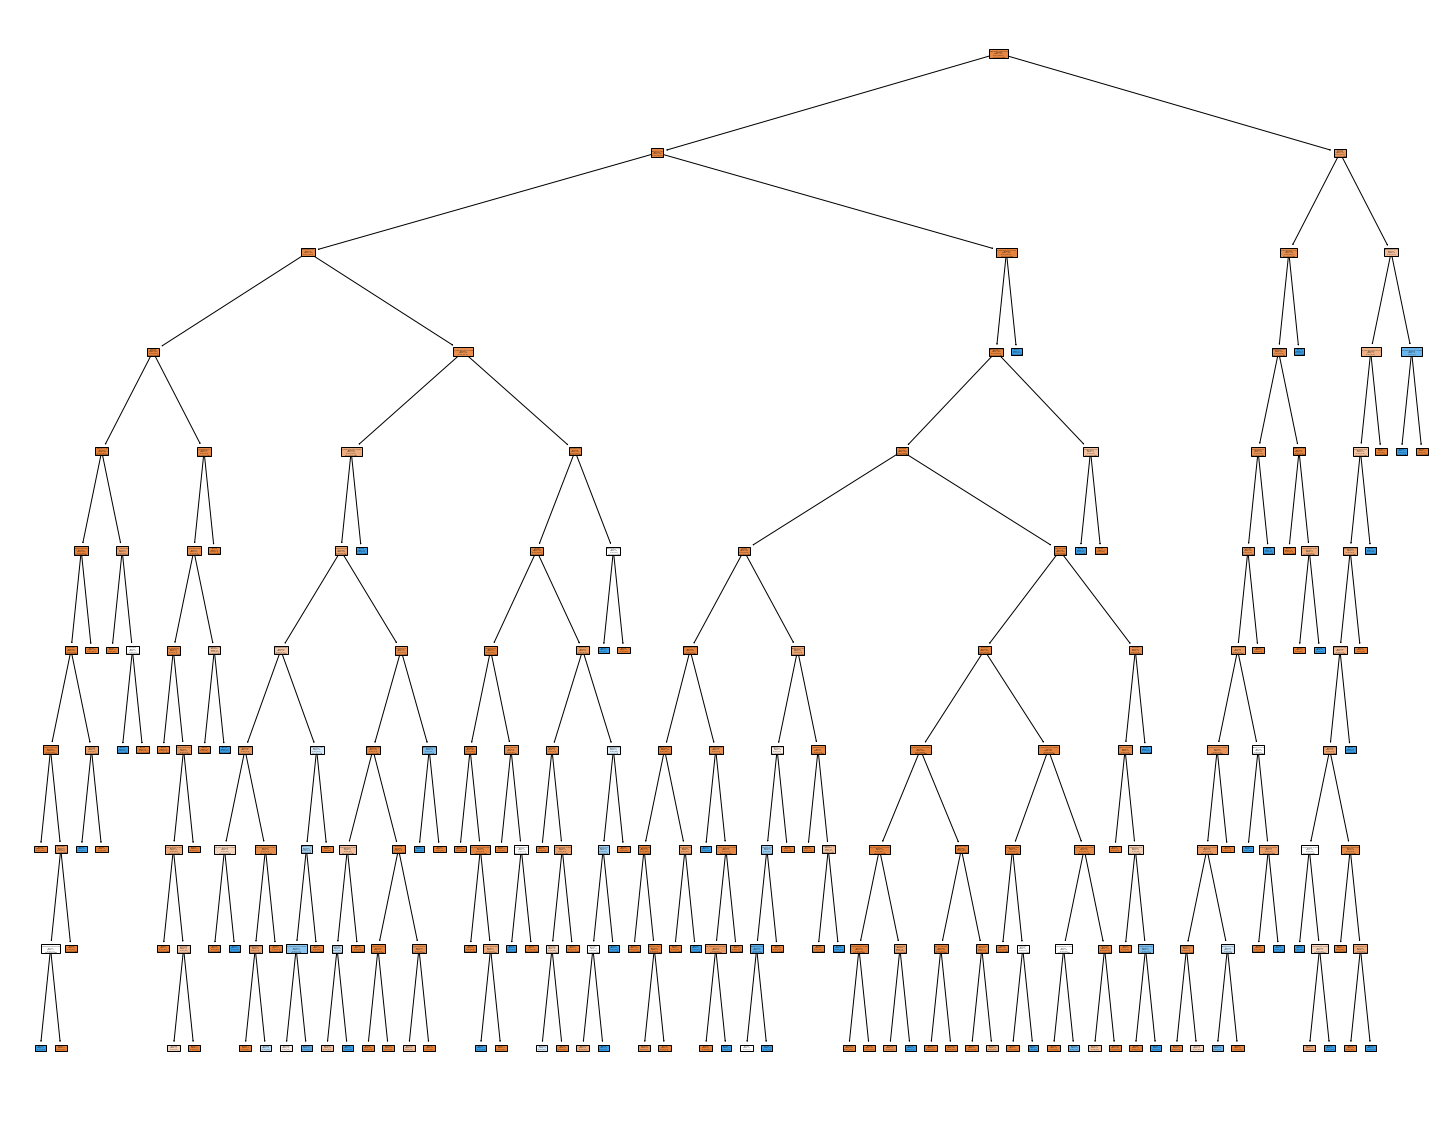

In [38]:
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=features,
                   class_names=['Не летальный', "Летальный"],
                   filled=True)
fig.savefig('features_graph.png')

In [39]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score
print(accuracy_score(y_train, y_train_pred))
confusion_matrix(y_train, y_train_pred)

0.9853333333333333


array([[3582,   11],
       [  44,  113]], dtype=int64)

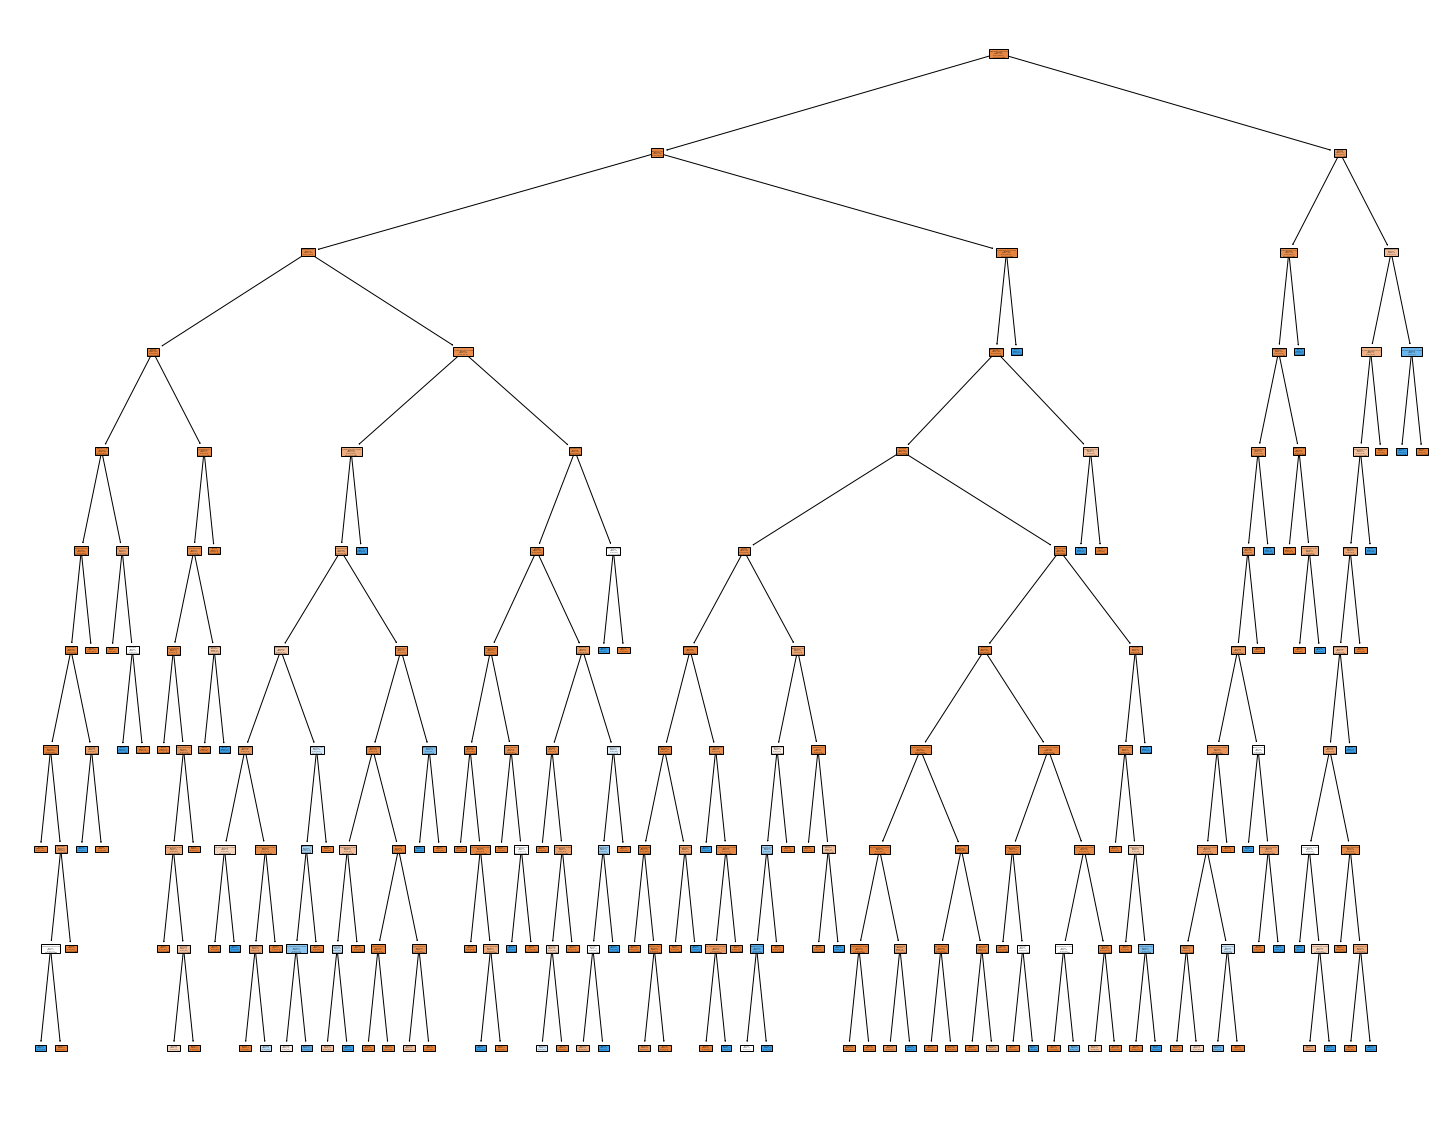

In [41]:
def get_dt_graph(clf):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(clf,
                       feature_names=features,
                       class_names=['Не летальный', "Летальный"],
                       filled=True)

gph = get_dt_graph(clf)

In [42]:
tree.export_graphviz(clf,
                     out_file="tree.dot",
                     feature_names = features,
                     class_names=['Не летальный', "Летальный"],
                     filled = True)

In [43]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [44]:
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y)
print(result)

AttributeError: 'dict' object has no attribute 'score'